# Bayesian methods for machine learning - Week 2

In [11]:
import os

import gif

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from mixture import (
    sample_mixture,
    sample_data,
    log_likelihood,
    sample_mu,
    sample_cov,
    sample_coefs
)

from visualization import (
    plot_data,
    data_vs_estimation_frame
)

## Gaussian Mixture Models (GMM) 

### Fitting through Expectation Maximization algorithm

### Reminder

We want to maximize the log likelihood of the data:

$$
\theta_{MLE} = \underset{\theta}{\mathrm{argmax}} \sum_i^N \log \sum_k^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)
$$

Given the set of parameters $\theta = \{ \pi_1, \pmb{\mu_1}, \pmb{\Sigma_1}, \ldots, \pi_K, \pmb{\mu_K}, \pmb{\Sigma_K} \}$, a set of i.i.d observations $\pmb{X} = \{\pmb{x_1}, \pmb{x_2}, \ldots, \pmb{x_N}\}$ and the corresponding latent variables $\pmb{Z} = \{ \pmb{z_1}, \pmb{z_2}, \ldots, \pmb{z_N} \}$.

Recall the following constraints must be satisfied for $\pi_k$:

- $\sum_i^M \pi_i = 1$
- $\pi_i \ge 0, \forall i = 1 \ldots M$

### Expectation Maximization algorithm

Expectation Maximization algorithm is a generic algorithm (and basis for Variational Inference) with broad applicability, which we will cover within the context of GMM. Note that K-means algorithm is a special type of EM algorithm.

Before diving into the two steps of the EM algorithm, let's see how we could get the maximum likelihood estimator for each of the parameters leaving the rest fixed.

#### Finding optimal centers

Let's find the formula for the optimal centers by finding the roots of the derivative with respect to $\pmb{\mu_k}$ for the log likelihood:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\mu_k}}} \log P(\pmb{X} | \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) & = \frac{\partial{f}}{\partial{\pmb{\mu_k}}} \sum^N_{i=1} \log \left[ \sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j}) \right]\\
                                                                         & = \sum^N_{i=1} \frac{\partial{f}}{\partial{\pmb{\mu_k}}} \log \left[ \sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j}) \right] \\
                                                                         & = \sum^N_{i=1} \frac{\frac{\partial{f}}{\partial{\pmb{\mu_k}}} \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} \\
                                                                         & = \sum^N_{i=1} \frac{\pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) \frac{\partial{f}}{\partial{\pmb{\mu_k}}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} \\
\end{align*}
$$

The Gaussian component with $\pmb{\mu_k}$ is the only one contributing to the derivative. Note the trick applied in the last step: Given the general formula for deriving a logarithm expression:

$$
\frac{\partial{}}{\partial{x}} \log f(x) = \frac{1}{f(x)} \frac{\partial{}}{\partial{x}} f(x) \implies \frac{\partial{}}{\partial{x}} f(x) = f(x) \frac{\partial{}}{\partial{x}} \log f(x)
$$

We can also use it to re-introduce a logarithm in our expression, so the preceding derivative is far easier to compute. Here, $f(x) = \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})$. We are going to use this replacement throughout this notebook.

Let's compute the log derivative of the Gaussian density with respect to $\pmb{\mu_k}$:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\mu_k}}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) & = \frac{\partial{f}}{\pmb{\partial{\mu_k}}} \log \left\{ \frac{\pi_k}{\sqrt{(2\pi^d)} \sqrt|\pmb{\Sigma_k}|} \exp \left[ \frac{-1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right] \right\}  \\                                                                                                & = \frac{\partial{f}}{\pmb{\partial{\mu_k}}} \left[ \log \pi_k - \left( \log \sqrt{(2\pi)^2)} + \log \sqrt{|\Sigma_k|} \right) + - \frac{1}{2} \left( \pmb{x_i}^{\top} \pmb{\Sigma_k}^{-1} \pmb{x_i} - \pmb{\mu_k}^{\top} \pmb{\Sigma_k}^{-1} \pmb{x_i} - \pmb{x_i}^{\top} \pmb{\Sigma_k}^{-1} \pmb{\mu_k} + \pmb{\mu_k}^{\top} \pmb{\Sigma_k}^{-1} \pmb{\mu_k} \right) \right]  \\ 
                                                                                                                & = - \frac{1}{2} \left(-\pmb{\Sigma_k}^{-1} \pmb{x_i} - \pmb{x_i}^{\top} \pmb{\Sigma_k}^{-1} + 2 \pmb{\Sigma_k}^{-1} \pmb{\mu_k} \right)
\end{align*}
$$

We have applied the matrix derivative rule $\frac{\partial}{\partial{\pmb{x}}} (\pmb{x}^{\top}\pmb{Ax}) = 2\pmb{Ax}$ for $\pmb{x} \in \mathcal{R}^{d}$, $\pmb{A} \in \mathcal{R}^{d \times d}$.

Given $\pmb{\Sigma_k}$ is symmetric, $(\pmb{\Sigma_k}^{-1})^{\top} = \pmb{\Sigma_k}^{-1}$. Therefore:

$$
(\pmb{\Sigma_k}^{-1} \pmb{x_i})^{\top} = \pmb{x_i}^{\top} (\pmb{\Sigma_k}^{-1})^{\top} = \pmb{x_i}^{\top} \pmb{\Sigma_k}^{-1}
$$

Then, we can rewrite the log derivative as:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\mu_k}}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) &= \pmb{\Sigma_k}^{-1} \pmb{x_i} - \pmb{\Sigma_k}^{-1} \pmb{\mu_k} \\
                                                                                                          &= \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k})
\end{align*}
$$

We can finish up writing $\frac{\partial{f}}{\partial{\pmb{\mu_k}}} P(\pmb{X} | \pmb{\mu}, \pmb{\Sigma})$:

$$
\frac{\partial{f}}{\partial{\pmb{\mu_k}}} \log P(\pmb{X} | \pmb{\mu}, \pmb{\Sigma}) = \sum^N_{i=1} \frac{\pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} \Sigma^{-1} (\pmb{x_i} - \pmb{\mu_j}) \\
$$

Note that we can write the derivative in terms of $P(z_k = 1|\pmb{x})$ (i.e. how much component $k$ explains $\pmb{x}$), which is defined as:

$$
\begin{align*}
P(z_k = 1 | \pmb{x}) & = \frac{P(\pmb{x} | z_k = 1)P(z_k = 1)}{P(\pmb{x}} \\
                     & = \frac{\pi_k \mathcal{N}(\pmb{x} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{i=1} \pi_i \mathcal{N}(\pmb{x} | \pmb{\mu_i}, \pmb{\Sigma_i})} \\
\end{align*}
$$

The terms $P(z_k | \pmb{x})$ are often referred as *responsabilities* in the literature.

Let's rewrite the derivative:

$$
\frac{\partial{f}}{\partial{\mu_k}} P(\pmb{X} | \pmb{\mu}, \pmb{\Sigma}) = \sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k})
$$

And the find roots of it:

$$
\begin{align*}
\sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) & = 0 \\
\sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{\Sigma}^{-1} \pmb{x_i}             & = \sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{\Sigma}^{-1} \pmb{\mu_k} \\
\sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{x_i}                               & = \sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{\mu_k} \implies \pmb{\mu_k} = \frac{\sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{x_i}}{\sum^N_{i=1} P(z_k | \pmb{x_i})} \\
\end{align*}
$$

Which gives, as a result, an intuitive formula: the optimal $\pmb{\mu_k}$ for a component is an average of the data points weighted by the posterior probability that the component generated that point.

#### Finding optimal sigmas

Let's do the same for the covariance matrix $\pmb{\Sigma_k}$:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \log P(\pmb{X} | \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) & = \sum^N_{i=1} \frac{\pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) \frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} \\
                                                                                       &= \sum^N_{i=1} P(z_k | \pmb{x_i}) \frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})
\end{align*}
$$

Let's find the derivative of the numerator:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \log \left\{ \frac{\pi_k}{\sqrt{(2\pi^d)} \sqrt|\pmb{\Sigma_k}|} \exp \left[ \frac{-1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right] \right\}  \\
                                                                                                        & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \left[ \log \pi_k - \left( \log \sqrt{(2\pi)^2)} + \log \sqrt{|\Sigma_k|} \right) - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right]  \\ 
                                                                                                        & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \left[ \log \pi_k - \left( \log \sqrt{(2\pi)^2)} + \frac{1}{2} \log |\Sigma_k| \right) - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k})] \right]  \\
                                                                                                        & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \left[ - \frac{1}{2} \log |\Sigma_k| - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right]  \\
                                                                                                        & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \left[ \frac{1}{2} \log |\Sigma_k|^{-1} - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right]  \\
                                                                                                        & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \left[ \frac{1}{2} \log |\Sigma_k^{-1}| - \frac{-1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right]  \\ 
\end{align*}
$$

Note that the last step can be applied as:

$$
|A^{-1}| = \frac{1}{|A|}
$$

Let's focus first on obtaining the derivative of $\log |\pmb{\Sigma_k}^{-1}|$. We know that:

$$
\frac{\partial{}}{\partial{A_{ij}}} \log |A| = \frac{1}{|A|} \frac{\partial{}}{\partial{A_{ij}}} |A|
$$

We know the determinant of a squared matrix $A \in \mathcal{R}^{n \times n}$ can be expressed in terms of minors (for any $i$):

$$
|A| = \sum^{n}_i (-1)^{i+j} a_{ij} M_{ij}
$$

Where $M_{ij}$ is the minor for $A_{ij}$, which is the matrix $A' \in \mathcal{R}^{(n-1) \times (n-1)}$ that results from removing row $i$ and column $j$ from $A$. And $a_{ij}$ is the value in row $i$ and column $j$ from $A$. If we take the derivative of the determinant with respect to $a_{ij}$, we see that it depends only on the *cofactors* $(-1)^{i+j} M_{ij}$, which conform the cofactor matrix $C$:

$$
\frac{\partial{}}{\partial{A_{ij}}} |A| = C
$$

We know, by definition of the adjugate matrix:

$$
\mathrm{Adj}(A) = C^{\top} \\
\mathrm{Adj}(A) = |A| A^{-1}
$$

Then:

$$
\begin{align*}
\frac{\partial{}}{\partial{A_{ij}}} \log |A| &= \frac{1}{|A|} \frac{\partial{}}{\partial{A_{ij}}} |A| \\
                                             &= \frac{1}{|A|} C \\
                                             &= \frac{1}{|A|} \mathrm{Adj}(A)^{\top} \\
                                             &= \frac{1}{|A|} |A| A^{{-1}^{\top}} \\
                                             &= A^{{-1}^{\top}} \\
\end{align*}
$$

Therefore, we can solve for the following:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \frac{1}{2} \log |\pmb{\Sigma_k}^{-1}| & = \frac{1}{2} \pmb{\Sigma_k}^{{-1}^{-\top}} \\
                                                                                    & = \frac{1}{2} \pmb{\Sigma_k}^{\top} \\
                                                                                    & = \frac{1}{2} \pmb{\Sigma_k}
\end{align*}
$$

As we know $\pmb{\Sigma_k}$ is symmetric, $\pmb{\Sigma_k} = \pmb{\Sigma_k}^{\top}$.

Now, let's focus on obtaining the derivative of the right-most expression:

$$
\frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k})
$$

Given column matrices $a \in \mathcal{R}^{1 \times d}$ and $b \in \mathcal{R}^{1 \times d}$, its product can be written as:

$$
\pmb{a}^{\top} \pmb{b} = \mathrm{trace}(\pmb{b} \pmb{a}^{\top})
$$

If we use the following naming convention:

$$
z = \pmb{x_i} - \pmb{\mu} \\
A = \pmb{\Sigma_k}^{-1}
$$

Then, $\pmb{z}^{\top}\pmb{A}$ is a column matrix and so is $\pmb{z}$. Therefore, their product can be written as:

$$
\begin{align*}
\pmb{z}^{\top} \pmb{A}\pmb{z} &= \mathrm{trace}(\pmb{z}\pmb{z}^{\top}\pmb{A})
\end{align*}
$$


It is also known that:

$$
\frac{\partial{f}}{\partial{\pmb{A}}} \mathrm{trace}(\pmb{B}\pmb{A}) = \pmb{B}^{\top}
$$

If we define $B = \pmb{z}\pmb{z}^{\top}$, then:

$$
\frac{\partial{f}}{\partial{\pmb{A}}} \mathrm{trace}(\pmb{z}\pmb{z}^{\top}A) = \pmb{z}\pmb{z}^{\top}
$$

Therefore, replacing back $z$ and $A$, we get:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) &= \frac{\partial{f}}{\partial{\pmb{A}}} -\frac{1}{2} \pmb{z}^{\top} A^{-1} \pmb{z} \\
                     &= - \frac{1}{2} \pmb{z}^{\top} \pmb{z} \\
                     &= - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu}) \\
\end{align*}
$$

Which leads to the following result:


$$
\begin{align*}
\frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) & = \frac{\partial{f}}{\pmb{\partial{\Sigma_k}}} \left( \frac{1}{2} \log |\pmb{\Sigma_k}^{-1}| - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right)  \\ 
                                                                                                        &= \frac{1}{2} \pmb{\Sigma_k} -\frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu})
\end{align*}
$$

We can now go back to the original log derivative with respect to $\pmb{\Sigma_k}$:

$$
\begin{align*}
\frac{\partial{f}}{\partial{\Sigma_k}} \log P(\pmb{X} | \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) &= \sum^N_{i=1} P(z_k | \pmb{x_i}) \frac{\partial{f}}{\partial{\pmb{\Sigma_k}}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) \\
                                                                                       & = \sum^N_{i=1} P(z_k | \pmb{x_i}) \left(\frac{1}{2} \pmb{\Sigma_k} - \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu}) \right) \\
                                                                                       & = \sum^N_{i=1} P(z_k | \pmb{x_i}) \frac{1}{2} \pmb{\Sigma_k} - \sum^N_{i=1} P(z_k | \pmb{x_i}) \frac{1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu}) \\
                                                                                       & = \frac{N \pmb{\Sigma_k}}{2} \sum^N_{i=1} P(z_k | \pmb{x_i})  -  \frac{N}{2} \sum^N_{i=1} P(z_k | \pmb{x_i}) (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu})
\end{align*}
$$

Now, if we find the roots of the derivative with respect to $\pmb{\Sigma_k}$:

$$
\begin{align*}
\frac{N \pmb{\Sigma_k}}{2} \sum^N_{i=1} P(z_k | \pmb{x_i}) -  \frac{N}{2} \sum^N_{i=1} P(z_k | \pmb{x_i}) (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu}) & = 0 \\
\frac{N \pmb{\Sigma_k}}{2} \sum^N_{i=1} P(z_k | \pmb{x_i}) & = \frac{N}{2} \sum^N_{i=1} P(z_k | \pmb{x_i}) (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu}) \\
\pmb{\Sigma_k} \sum^N_{i=1} P(z_k | \pmb{x_i}) & = \sum^N_{i=1} P(z_k | \pmb{x_i}) (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu}) \\
\pmb{\Sigma_k} & = \frac{\sum^N_{i=1} P(z_k | \pmb{x_i}) (\pmb{x_i} - \pmb{\mu})^{\top} (\pmb{x_i} - \pmb{\mu})}{\sum^N_{i=1} P(z_k | \pmb{x_i})}
\end{align*}
$$

#### Finding optimal mixture coefficients

Let's repeat the procedure with respect to $\pi_k$. In this case, though, we need to add a constraint to the optimization: the sum of coefficients must sum to one. In order to do that, we are going to add a Lagrange multiplier term to the optimization function.

**Recap: Lagrange multiplier**

We assume we want to get the optimal points of a function $f(\pmb{x})$ subject to a function $g(\pmb{x})=0$, given vector $\pmb{x} = (x_1, x_2, \ldots, x_D)$. Given the following theorem:

> If the function $f$ is differentiable, the gradient of $f$ at a point is either zero, or perpendicular to the level set of $f$ at that point.

We know that points where there are optimal values of $f(\pmb{x})$ subject to $g(\pmb{x})=0$ are where the directions of the gradients of both are the same, but differ in magnitude (i.e. scaled by scalar $\lambda$). See an image for a more visual explanation ([source](https://bjlkeng.github.io/posts/lagrange-multipliers/)):

<img src="images/lagrange.png">

That is:

$$
\begin{cases}
\nabla f(\pmb{x}) = \lambda \nabla g(\pmb{x}) \\
g(x) = 0
\end{cases}
$$

Optimizing for $f$ given the constraints above is equivalent to optimizing the *Lagragian* function:

$$
\mathcal{L}(x, \lambda) = \nabla f(\pmb{x}) - \lambda \nabla g(\pmb{x})
$$

Therefore, setting the derivative of the $Lagrangian$ to zero, we get:

$$
\nabla_{x, \lambda} \mathcal{L}(\pmb{x}, \lambda) = 0 \\
\Longleftrightarrow \frac{\partial}{\partial{x_1}} f(\pmb{x}) - \lambda \frac{\partial}{\partial{x_1}} g(\pmb{x}) = 0 \\
\ldots \\
\Longleftrightarrow \frac{\partial}{\partial{x_D}} f(\pmb{x}) - \lambda \frac{\partial}{\partial{x_D}} g(\pmb{x}) = 0 \\
\Longleftrightarrow \frac{\partial}{\partial{x}} f(x) - \lambda \frac{\partial}{\partial{x}} g(x) = 0 \\
g(\pmb{x}) = 0
$$

Note that we will have $D$ + $M$ equations, where $D$ is the number of dimensions and $M$ is the number of constraints (i.e. 1 above). The general form for $M$ constraints is:

$$
\mathcal{L}(x_1, \ldots, x_D \lambda_1, \ldots, \lambda_M) = f(x_1, \ldots, x_d) - \sum^M_{m=1} \lambda_m g_m(x_1, \ldots, x_D)
$$

**Adding Lagrange constraint**

We have one constraint:

$$
g_1(\pi) = \left( \sum^K_{k=0} \pi_k \right) - 1 = 0
$$

and maximization objective:

$$
\frac{\partial{f}}{\partial{\pi_k}} \log P(\pmb{X} | \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma})
$$

Therefore, the constrained function to maximize is:

$$
\begin{align*}
f(\pmb{X}, \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) & = \frac{\partial{f}}{\partial{\pi_k}} \log P(\pmb{X} | \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) - \lambda \left(1 - \sum^K_{k=0} \pi_k \right) \\
\frac{\partial{}}{\partial{\pi_k}} f(\pmb{X}, \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) & = \frac{\partial{f}}{\partial{\pi_k}} \sum^N_{i=1} \log \left[ \sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j}) \right] - \lambda \left(1 - \sum^K_{k=0} \pi_k \right) \\
                                                                                    & = \sum^N_{i=1} \frac{\pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) \frac{\partial{f}}{\partial{\pi_k}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} - \lambda \\
\end{align*}
$$

It is easy to see that:

$$
\begin{align*}
\frac{\partial{}}{\partial{\pi_k}} \log \pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) & = \frac{\partial{f}}{\pmb{\partial{\mu_k}}} \log \left\{ \frac{\pi_k}{\sqrt{(2\pi^d)} \sqrt|\pmb{\Sigma_k}|} \exp \left[ \frac{-1}{2} (\pmb{x_i} - \pmb{\mu})^{\top} \pmb{\Sigma_k}^{-1} (\pmb{x_i} - \pmb{\mu_k}) \right] \right\}  \\
                                                                                                    & = \frac{1}{\pi_k}
\end{align*}
$$


Therefore:

$$
\begin{align*}
\frac{\partial}{\partial{\pi_k}} f(\pmb{X}, \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) & = \sum^N_{i=1} \frac{\pi_k \mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k}) \frac{1}{\pi_k}}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} - \lambda \\
\frac{\partial}{\partial{\pi_k}} f(\pmb{X}, \pmb{\pi}, \pmb{\mu}, \pmb{\Sigma}) & = \sum^N_{i=1} \frac{\mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} - \lambda \\
\end{align*}
$$

If we find the roots of the resulting expression:

$$
\begin{align*}
\sum^N_{i=1} \frac{\mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} - \lambda & = 0 \\
\sum^N_{i=1} \pi_k \frac{\mathcal{N}(\pmb{x_i} | \pmb{\mu_k}, \pmb{\Sigma_k})}{\sum^K_{j=1} \pi_j \mathcal{N}(\pmb{x_i} | \pmb{\mu_j}, \pmb{\Sigma_j})} & = \pi_k \lambda \\
\sum^N_{i=1} P(z_k | \pmb{x_i}) & = \pi_k \lambda \\
\frac{1}{\lambda} \sum^N_{i=1} P(z_k | \pmb{x_i}) & = \pi_k
\end{align*}
$$

We can then sum over the $K$ components on both sides:

$$
\sum^K_{k=1} \frac{1}{\lambda} \sum^N_{i=1} P(z_k | \pmb{x_i}) = \sum^K_{k=1} \pi_k
$$

Remember we have constraint $\sum_k \pi_k = 1$. Then:

$$
\begin{align*}
\sum^K_{k=1} \frac{1}{\lambda} \sum^N_{i=1} P(z_k | \pmb{x_i}) & = 1 \\
\frac{1}{\lambda} \sum^K_{k=1} \sum^N_{i=1} P(z_k | \pmb{x_i}) & = 1 \\
\frac{1}{\lambda} \sum^N_{i=1} \sum^K_{k=1} P(z_k | \pmb{x_i}) & = 1 \\
\frac{1}{\lambda} \sum^N_{i=1} 1 & = 1 \\
\frac{N}{\lambda} & = 1 \implies \lambda = N \\
\end{align*}
$$

Then we can compute the maximum likelihood estimator for $\pi_k$:

$$
\pi_k = \frac{1}{N} \sum^N_{i=1} P(z_k | \pmb{x_i})
$$

We see it is quite intuitive that the MLE is estimated as the average of the posterior over all data points.

#### Expectation and maximization steps

The MLE expressions above do not have a closed solution. However, they suggest an iterative update process. First, initial values are selected for the vector of means, variance matrices and mixing coefficients (it is common to use the output of K-Means as initialization). Then, alternatig expectation and maximization steps are performed.

We are going to describe the steps that we are implementing.

**1- Initialization**

As with any other gradient-based approach, we need to initialize each of the variables. We will use random initialization on the interval of the data.

Note that it is also common to initialize the parameters with the ouput of the K-means algorithm:

- $\pmb{\mu}$ is initialized to the set of discovered clusters.
- $\pmb{\Sigma}$ is initialized as the sample covariances of each the clusters.
- $\pi$ is initialized to the rate of instances for each of the clusters.

**2- E step**

Given the current set of parameters, *responsabilities* $P(z_k | \pmb{x_i})$ are evaluated.

**3- M step**

Given *responsabilities* $P(z_k | \pmb{x_i})$ from E-step, parameters are re-estimated at iteration $t$ by using the formulas provided in the derivation above:

$$
\pmb{\mu_k}^{t} = \frac{\sum^N_{i=1} P(z_k | \pmb{x_i}) \pmb{x_i}}{\sum^N_{i=1} P(z_k | \pmb{x_i})}
$$

$$
\pmb{\Sigma_k}^{t} = \frac{\sum^N_{i=1} P(z_k | \pmb{x_i}) (\pmb{x_i} - \pmb{\mu^{t}})^{\top} (\pmb{x_i} - \pmb{\mu^{t}})}{\sum^N_{i=1} P(z_k | \pmb{x_i})}
$$

$$
\pi_k^{t} = \frac{1}{N} \sum^N_{i=1} P(z_k | \pmb{x_i})
$$

Note that the order of the estimation matters. First, we are computing $\pmb{\mu_k}^{t}$ and then we are using its value to compute $\pmb{\Sigma_k}^{t}$.

**4- Evaluation step**

Evaluate the log likelihood function and, if it has not converged, start a new iteration from the expectation step (i.e. back to step 2).

Note that singularities may also occur during the EM algorithm and additional actions may be required to ensure we find a solution.

## Load data

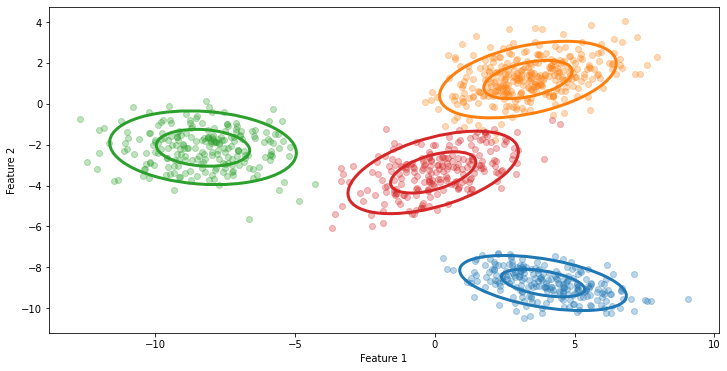

In [12]:
true_mus, true_sigmas, true_coefs = sample_mixture()
X, y = sample_data(mus=true_mus,
                   sigmas=true_sigmas,
                   coefs=true_coefs)

n_clusters, n_features = true_mus.shape[:2]

# Show data
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

plot_data(X=X,
          y=y,
          mus=true_mus,
          sigmas=true_sigmas,
          ax=ax)

## Implementing EM algorithm for GMM

Random initialization.

In [13]:
init_coefs = sample_coefs(n_clusters)

init_mus = np.stack([
    sample_mu(X.min(axis=0), X.max(axis=0))
    for i in range(n_clusters)
])

init_sigmas = np.stack([
    sample_cov(n_features)
    for i in range(n_clusters)
])

Evaluate likelihood at the beginning.

In [14]:
init_likelihood = log_likelihood(X=X,
                                 mus=init_mus,
                                 sigmas=init_sigmas,
                                 coefs=init_coefs)
true_likelihood = log_likelihood(X=X,
                                 mus=true_mus,
                                 sigmas=true_sigmas,
                                 coefs=true_coefs)
print(
    f'''
    True likelihood: {true_likelihood:.4f}
    Initial likelihood: {init_likelihood:.4f}
    '''
)


    True likelihood: -4452.3845
    Initial likelihood: -14536.9356
    


Implement E and M step.

In [15]:
def e_step(X: np.ndarray,
           mus: np.ndarray,
           sigmas: np.ndarray,
           coefs: np.ndarray) -> np.ndarray:
    """
    Returns estimated responsabilities, which is a [N x k]
    matrix where ith row contains the probability that each
    row belongs to each of the clusters
    """
    n_clusters = mus.shape[0]
    result = np.zeros((X.shape[0], n_clusters))
    for i in range(n_clusters):
        result[:, i] = coefs[i] * multivariate_normal(mean=mus[i],
                                                      cov=sigmas[i]).pdf(X)

    return result / result.sum(axis=1)[:, None]


def m_step(X: np.ndarray, responsabilities: np.ndarray):
    """
    Returns the newly computed mus, sigmas and coefs after
    performing a maximum likelihood maximization step
    """
    n_clusters = responsabilities.shape[1]
    n_features = X.shape[1]
    n_k = responsabilities.sum(axis=0)
    
    # Compute center vectors
    mus = np.dot(responsabilities.T, X) / n_k[:, None]

    # Compute covariance matrices
    sigmas = np.zeros((n_clusters, n_features, n_features))
    for i in range(n_clusters):
        sigmas[i, ...] = np.dot(
            (responsabilities[:, i, None] * (X - mus[i])).T,
            (X - mus[i])
        ) / n_k[i]
    
    # Compute mixing coefficients
    coefs = n_k / len(X)
    
    return mus, sigmas, coefs

Perform training loop.

In [16]:
mus = init_mus
sigmas = init_sigmas
coefs = init_coefs

stats_interval = 5
plot_interval = 1
frames = []

likelihoods = []
n_iterations = 25
for iteration in range(n_iterations):
    
    # E-step
    responsabilities = e_step(X, mus, sigmas, coefs)
    
    # M-step
    mus, sigmas, coefs = m_step(X, responsabilities)
    
    # Evaluation step
    likelihood = log_likelihood(X=X,
                                mus=mus,
                                sigmas=sigmas,
                                coefs=coefs)
    
    if iteration % stats_interval == 0:
        print(f'[{iteration}] Log likelihood: {likelihood:.2f}')

    if iteration % plot_interval == 0:
        frame = data_vs_estimation_frame(
            X=X,
            y=y,
            true_mus=true_mus,
            true_sigmas=true_sigmas,
            mus=mus,
            sigmas=sigmas,
            figsize=(12, 5),
            epoch=iteration
        )
        frames.append(frame)

    # Keep track of likelihoods for plotting
    likelihoods.append(likelihood)


[0] Log likelihood: -5005.94
[5] Log likelihood: -4544.30
[10] Log likelihood: -4445.27
[15] Log likelihood: -4444.88
[20] Log likelihood: -4444.88


Let's plot the likelihood through the optimization process.

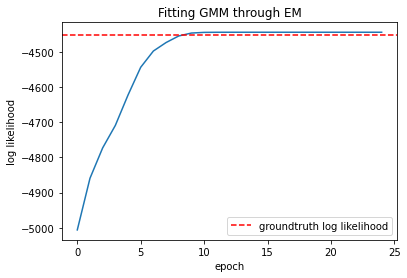

In [17]:
plt.plot(range(n_iterations), likelihoods)
plt.xlabel('epoch')
plt.ylabel('log likelihood')
plt.axhline(true_likelihood,
            label='groundtruth log likelihood',
            color='red',
            linestyle='--')
plt.title('Fitting GMM through EM');
plt.legend()

Let's visualize the computed parameters.

In [18]:
print(
    f'''
Estimated weights: \n{coefs}
Real weights: \n{true_coefs}

Estimated centers: \n{mus}
Real centers: \n{true_mus}

Estimated sigmas: \n{sigmas}
Real sigmas: \n{true_sigmas}
    '''
)


Estimated weights: 
[0.2340008  0.22908225 0.31706872 0.21984822]
Real weights: 
[0.24023278 0.31508254 0.21823632 0.22644836]

Estimated centers: 
[[ 4.02289706 -8.79419603]
 [ 0.10762685 -3.24994879]
 [ 3.39915208  1.29321014]
 [-8.32301479 -2.16140064]]
Real centers: 
[[ 3.87359054 -8.76566015]
 [ 3.33223195  1.18417874]
 [-8.29778754 -2.15161887]
 [-0.05844945 -3.35701851]]

Estimated sigmas: 
[[[ 2.32865188 -0.51033319]
  [-0.51033319  0.48248252]]

 [[ 2.44764641  0.89679369]
  [ 0.89679369  1.20701563]]

 [[ 2.49107962  0.52181583]
  [ 0.52181583  0.84557157]]

 [[ 2.54608345 -0.0803369 ]
  [-0.0803369   0.86120036]]]
Real sigmas: 
[[[ 2.22368781 -0.46692735]
  [-0.46692735  0.4545174 ]]

 [[ 2.50008149  0.62752786]
  [ 0.62752786  0.87694685]]

 [[ 2.79125064 -0.20990057]
  [-0.20990057  0.81232486]]

 [[ 2.32688166  0.77814247]
  [ 0.77814247  1.01659411]]]
    


In [21]:
animation_path = os.path.join('media', 'gmm_em.gif')

if not os.path.isfile(animation_path):
    gif.save(frames, animation_path, duration=250)

![SegmentLocal](media/gmm_em.gif )

We have seen how it takes less iterations to get to the proper solution using the EM algorithm than using numerical optimization. Moreover, we even get a higher likelihood than the groundtruth one.

## Future work

- [ ] Use data classes for Gaussian components to avoid passing so many arguments.
- [ ] Check convergence during training